In [38]:
%matplotlib inline

import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from PIL import Image

lr = 7.0
size = 224
iterations = 500
style_wt = 1e2
content_wt = 1.0


print("TensorFlow version:", tf.__version__)

style_layer_wts = [1.0, 0.3, 0.1, 0.1, 0.2]

TensorFlow version: 2.2.0


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
model = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(size, size, 3))
model.trainable = False
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [4]:
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(size, size))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return np.expand_dims(img, axis = 0)

In [103]:
def deprocess(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_image(image):
    if len(image.shape) == 4:
        image = image[0,:,:,:]

    

    img = deprocess(image)
    

    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()

In [152]:
content_image_path = "drive/My Drive/Projects/NST/DSC_1079.JPG"
style_image_path = "drive/My Drive/Projects/NST/style.jpg"

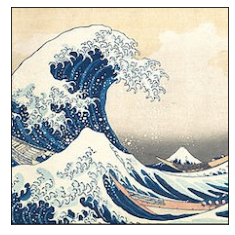

In [119]:
display_image(preprocess_image(style_image_path))

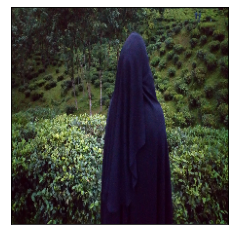

In [153]:
display_image(preprocess_image(content_image_path))

In [132]:
content_layer = 'block4_conv2'

content_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=model.get_layer(content_layer).output
)

In [9]:
style_layers = [
    'block1_conv1', 'block1_conv2',
    'block2_conv1', 'block2_conv2',
    'block3_conv1'
    ]

style_models = [
    tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer).output)
    for layer in style_layers
]

In [10]:
def content_cost(content_img, generated_img):
    C = content_model(content_img)
    G = content_model(generated_img)
    cost = tf.reduce_mean(tf.square(C - G))
    return cost

In [11]:
def gram_matrix(M):
    num_channels = tf.shape(M)[-1]
    M = tf.reshape(M, shape=(-1, num_channels))
    n = tf.shape(M)[0]
    G = tf.matmul(tf.transpose(M), M)
    return G / tf.cast(n, dtype=tf.float32)

In [12]:
def style_cost(style_img, generated_img):
    total_cost = 0
    
    for i, style_model in enumerate(style_models):
        S = style_model(style_img)
        G = style_model(generated_img)
        GS = gram_matrix(S)
        GG = gram_matrix(G)
        current_cost = style_layer_wts[i] * tf.reduce_mean(tf.square(GS - GG))
        total_cost += current_cost
    
    total_cost /= (size * size * len(style_models))
    return total_cost

In [51]:
style_layer_wts = [1.0, 0.5, 0.1, 0.1, 0.2]

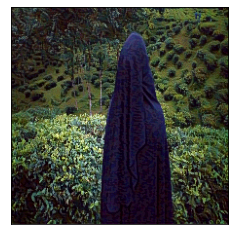

Iteration:1/100, Total Cost:6997480.5, Style Cost: 6997.48046875, Content Cost: 0.0


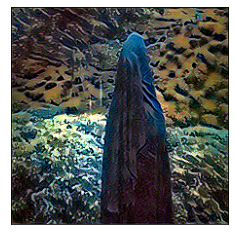

Iteration:21/100, Total Cost:3067273.5, Style Cost: 2812.025146484375, Content Cost: 255248.34375


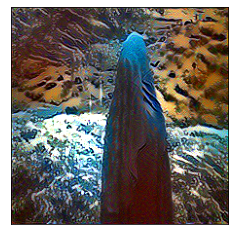

Iteration:41/100, Total Cost:1931171.625, Style Cost: 1691.8751220703125, Content Cost: 239296.484375


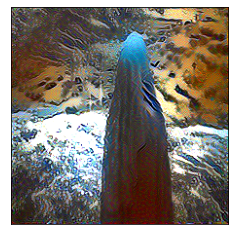

Iteration:61/100, Total Cost:859951.4375, Style Cost: 618.0909423828125, Content Cost: 241860.484375


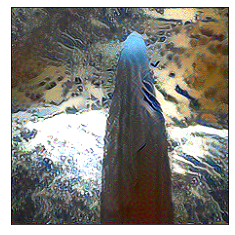

Iteration:81/100, Total Cost:425346.0, Style Cost: 202.70118713378906, Content Cost: 222644.796875


In [158]:
content_image_preprocessed = preprocess_image(content_image_path)
style_image_preprocessed = preprocess_image(style_image_path)
generated_image = tf.Variable(content_image_preprocessed, dtype=tf.float32)

generated_images = []
costs = []

optimizer = tf.optimizers.Adam(learning_rate=lr)


lr = 7.0
size = 224
iterations = 100
style_wt = 1e3
content_wt = 1.0


for i in range(iterations):
    
    with tf.GradientTape() as tape:
        J_content = content_cost(content_img=content_image_preprocessed, generated_img=generated_image)
        J_style = style_cost(style_img=style_image_preprocessed, generated_img=generated_image)
        J_total = content_wt * J_content + style_wt * J_style
    
    gradients = tape.gradient(J_total, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])
    
    costs.append(J_total.numpy())
    
    if i % 20 == 0:
        display_image(generated_image.numpy())
        generated_images.append(generated_image.numpy())
        print("Iteration:{}/{}, Total Cost:{}, Style Cost: {}, Content Cost: {}".format(i+1, iterations, J_total, J_style, J_content))

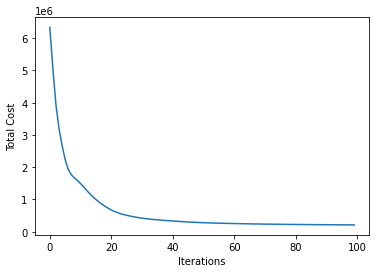

In [149]:
plt.plot(range(iterations), costs)
plt.xlabel("Iterations")
plt.ylabel("Total Cost")
plt.show()

In [144]:
generated_images

[array([[[[-6.93896294e+00, -8.77894974e+00, -2.36800156e+01],
          [-4.93895960e+00, -6.77884483e+00, -2.16800499e+01],
          [-5.93462038e+00,  6.22090006e+00, -2.26797981e+01],
          ...,
          [ 6.09908104e-02, -7.77955675e+00, -1.16800213e+01],
          [-9.38911915e-01, -8.77890015e+00, -1.26798744e+01],
          [-9.38911915e-01, -8.77887726e+00, -1.26798706e+01]],
 
         [[-6.93904400e+00, -8.77905464e+00, -2.36801033e+01],
          [-4.93902826e+00, -6.77902699e+00, -2.16801300e+01],
          [-5.93891573e+00, -7.77860451e+00, -2.26801262e+01],
          ...,
          [-1.59391308e+01, -2.37791729e+01, -2.76801624e+01],
          [-9.39642429e-01, -2.27791100e+01, -2.66797829e+01],
          [-9.38922405e-01, -8.77897263e+00, -1.26798973e+01]],
 
         [[-5.93904257e+00, -7.77902174e+00, -2.26801147e+01],
          [-5.93912458e+00, -7.77911711e+00, -2.26801643e+01],
          [-5.93911076e+00, -7.77909613e+00, -2.26801682e+01],
          ...,
    

In [159]:
image = Image.fromarray(deprocess(generated_images[-1][0]))

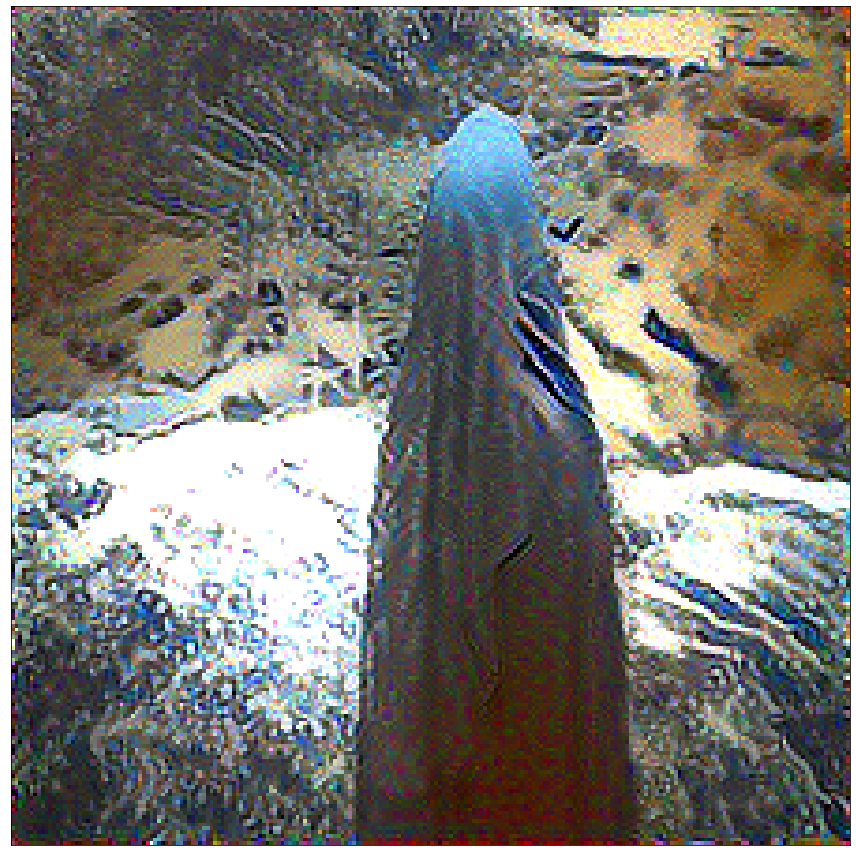

In [160]:
plt.figure(figsize= (12,12))
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('img9.png')